In [1]:
%cd ..

/Users/knpob/Territory/Kolmo/code/footprint-to-pressure-unified


In [2]:
import torch

torch.manual_seed(0)

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Load options

In [3]:
from src.tool import config

path = 'experiment/mlp-0620'
opt = config.load_config(path)
opt.path = path
print(opt)

dataloader:
  args:
    batch_size: 1
    shuffle: True
  name: DataLoader
dataset:
  args:
    footprint_wrap_folder: data/processed/footprint-wrap/
    img_size: 10
    pedar_dynamic_path: data/processed/pedar_dynamic.pkl
    sense_range: 600
    stack_range: 50
  name: Footprint2Pressure_Blend_SensorStack
  train_ratio: 0.8
device_select: auto
loss:
  args:
    
  name: MSELoss
metric:
  MAE:
    args:
      
    name: L1Loss
  MSE:
    args:
      
    name: MSELoss
model:
  args:
    hidden: 2048
    img_size: 10
    pos_emb_len: 512
    young_emb_len: 128
  name: MLP_cos_emb
optimizer:
  args:
    lr: 0.1
  epochs: 50
  name: SGD
path: experiment/mlp-0620
train_script: TrainScrip_RandomSplit
use_pretrain: False


## Load dataset & model

In [4]:
from src.tool.registry import SCRIPT_REGISTRY

train_script = SCRIPT_REGISTRY[opt.train_script](opt)
train_script.load_data()
train_script.train_prep()

training on mps...


In [5]:
from pathlib import Path

model = train_script.model
model.load_state_dict(torch.load(Path(train_script.opt.path) / 'model.pth'))

<All keys matched successfully>

In [6]:
(img_stack, sensor_id), pedar_gt = train_script.full_dataset.__getitem__(3)
img_stack.shape, sensor_id.shape, pedar_gt.shape

(torch.Size([198, 10, 10]), torch.Size([]), torch.Size([198]))

pred_std	0.0419468991458416	pred_mean	0.10240224748849869
gt_std		0.046527884900569916	gt_mean		0.11419029533863068


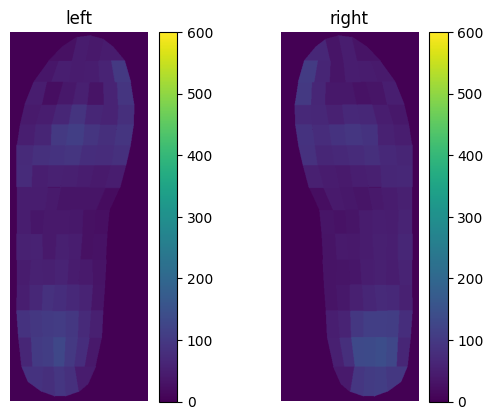

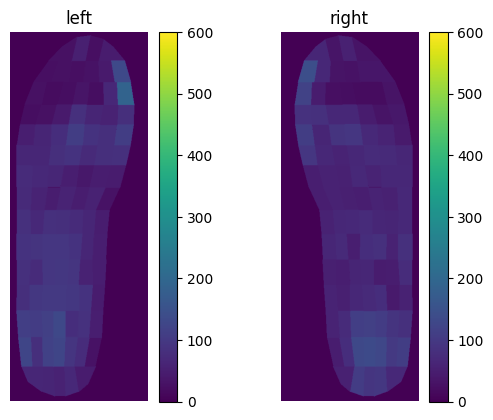

In [7]:
from src.tool import visual

pedar_pred = model((img_stack, sensor_id))

print(f'pred_std\t{pedar_pred.std().item()}\tpred_mean\t{pedar_pred.mean().item()}')
print(f'gt_std\t\t{pedar_gt.std().item()}\tgt_mean\t\t{pedar_gt.mean().item()}')

visual.draw_heatmap(pedar_pred.cpu().detach().numpy() * 600, 'data/processed/left_foot_mask.png')
visual.draw_heatmap(pedar_gt.cpu().detach().numpy() * 600, 'data/processed/left_foot_mask.png')

In [8]:
train_script.loss_fn(pedar_pred, pedar_gt)

tensor(0.0012, device='mps:0', grad_fn=<MseLossBackward0>)

young's modulus - 1.00 (MPa)


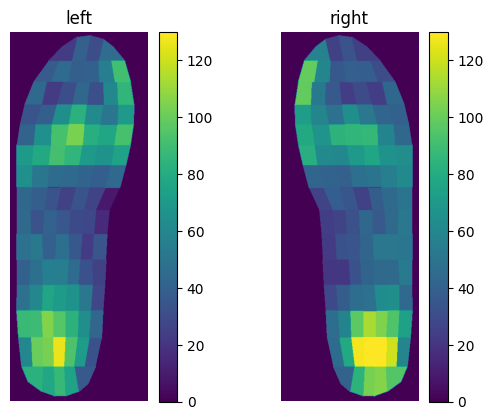

young's modulus - 1.50 (MPa)


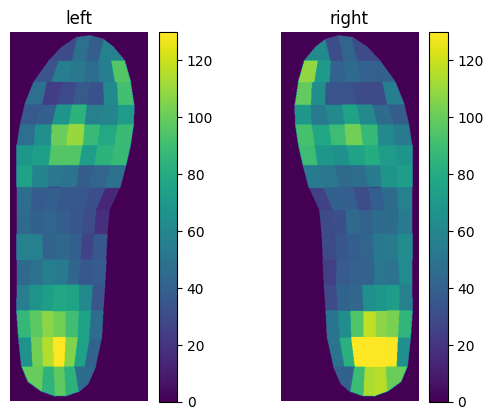

young's modulus - 2.00 (MPa)


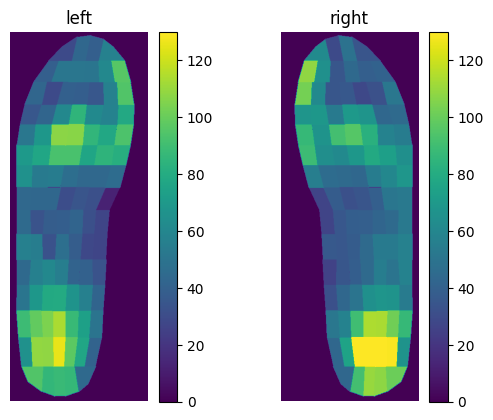

young's modulus - 2.50 (MPa)


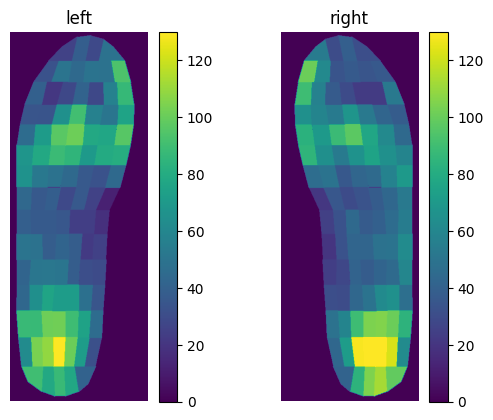

young's modulus - 3.00 (MPa)


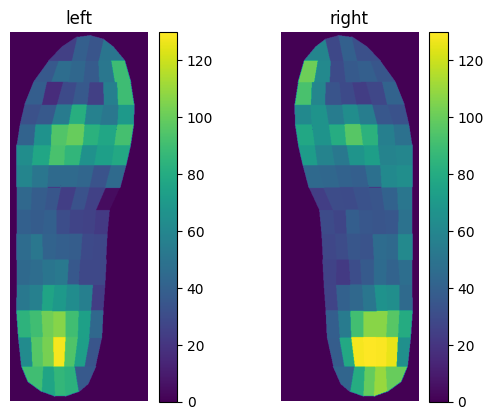

young's modulus - 3.50 (MPa)


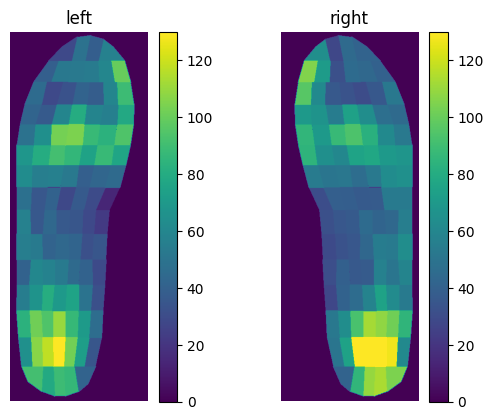

young's modulus - 4.00 (MPa)


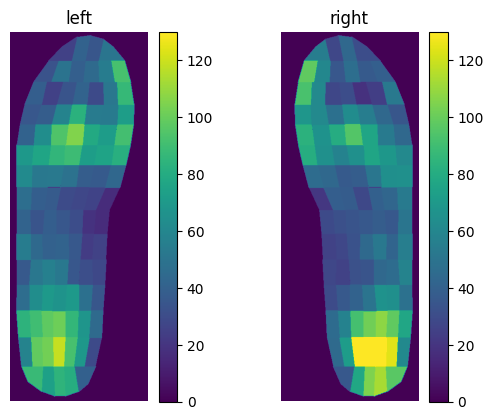

young's modulus - 4.50 (MPa)


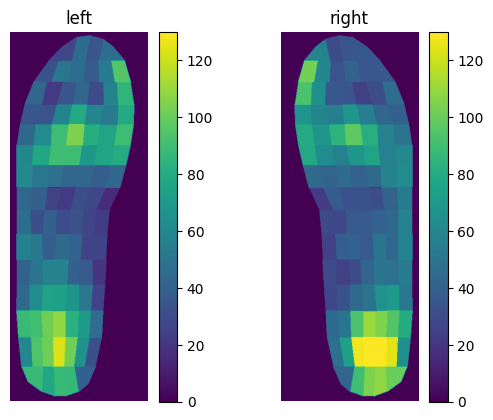

In [14]:
import numpy as np

for idx in np.arange(1.0, 5.0, 0.5):
    pedar_pred = model((img_stack, torch.tensor(idx, dtype=torch.float32).to(device)))
    print(f"young's modulus - {idx:.2f} (MPa)")
    visual.draw_heatmap(
        pedar_pred.cpu().detach().numpy() * 600,
        'data/processed/left_foot_mask.png',
        vmax=130, is_export=True, export_path=Path(path) / f'output/pred/{idx:.2f}.png',
        )

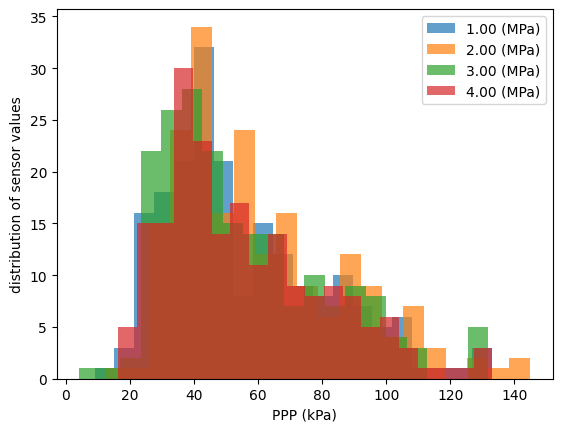

In [16]:
import matplotlib.pyplot as plt

pedar_pred0 = model((img_stack, torch.tensor(1.0).to(device)))

for idx in np.arange(1.0, 5.0):
    pedar_pred = model((img_stack, torch.tensor(idx, dtype=torch.float32).to(device)))
    plt.hist(pedar_pred.cpu().detach().numpy() * 600, 20, alpha=0.7, label=f'{idx:.2f} (MPa)')#, histtype='step')

plt.legend()
plt.ylabel('distribution of sensor values')
plt.xlabel('PPP (kPa)')
plt.savefig(Path(path) / f'output/distribution.png')
plt.show()

young's modulus - diff(1.50, 1.00) (MPa)
min -6.24 max 17.71


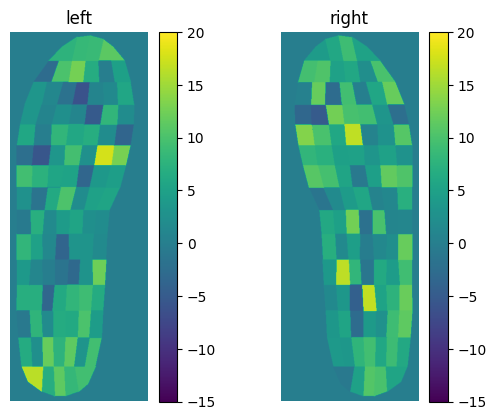

young's modulus - diff(2.00, 1.00) (MPa)
min -7.21 max 18.66


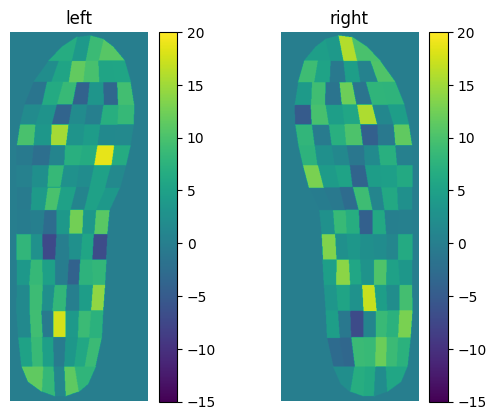

young's modulus - diff(2.50, 1.00) (MPa)
min -9.48 max 13.28


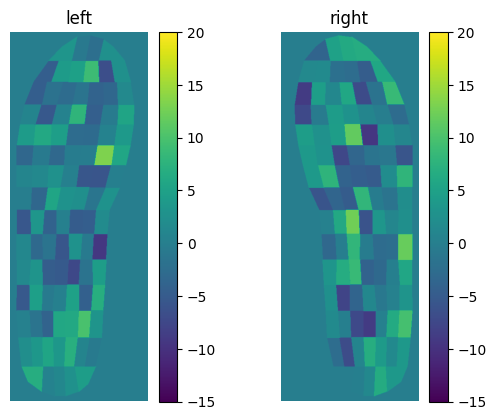

young's modulus - diff(3.00, 1.00) (MPa)
min -11.22 max 10.52


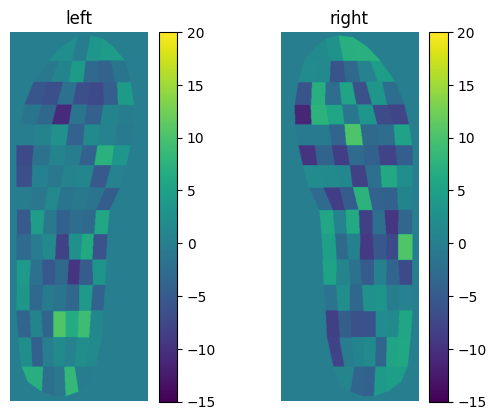

young's modulus - diff(3.50, 1.00) (MPa)
min -10.96 max 21.67


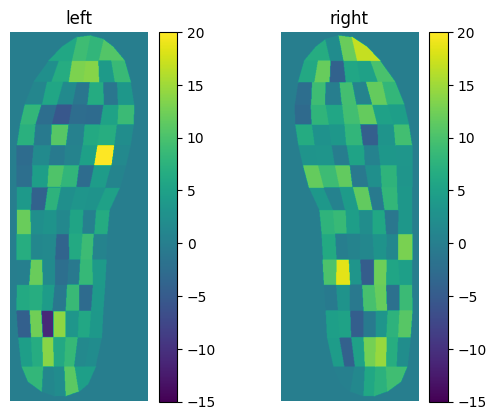

young's modulus - diff(4.00, 1.00) (MPa)
min -11.60 max 10.61


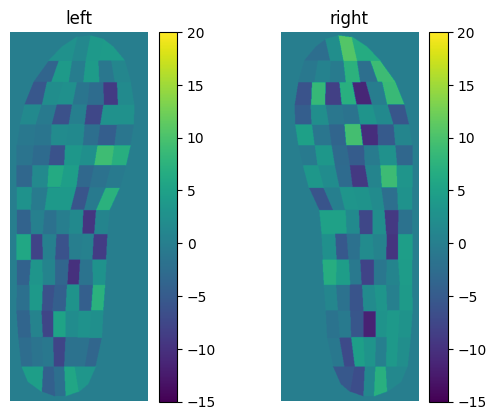

young's modulus - diff(4.50, 1.00) (MPa)
min -10.24 max 13.24


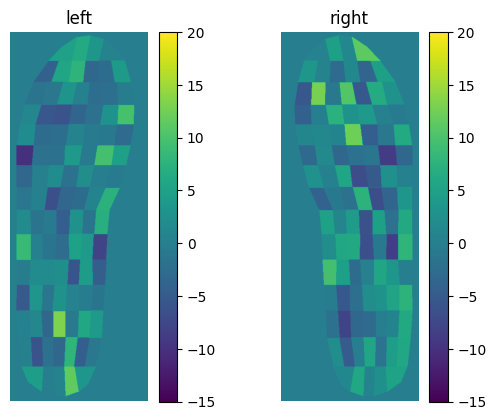

In [17]:
pedar_pred0 = model((img_stack, torch.tensor(1.0).to(device)))

for idx in np.arange(1.5, 5.0, 0.5):
    pedar_pred1 = model((img_stack, torch.tensor(idx, dtype=torch.float32).to(device)))
    diff = (pedar_pred1 - pedar_pred0).cpu().detach().numpy() * 600
    print(f"young's modulus - diff({idx:.2f}, {1:.2f}) (MPa)")
    print(f"min {diff.min():.2f} max {diff.max():.2f}")
    visual.draw_heatmap(
        diff,
        'data/processed/left_foot_mask.png',
        vmax=20, vmin=-15,# cmap='cool',
        is_export=True, export_path=Path(path) / f'output/diff/{idx:.2f}-{1:.2f}.png',
        )